In [121]:
from IPython.display import HTML
'''
HTML(
<script>
<!-- Code block to hind code boxes for PDF printing-->
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    document.body.style.fontFamily='Palatino';
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.)
'''

'\nHTML(\n<script>\n<!-- Code block to hind code boxes for PDF printing-->\ncode_show=false;\nfunction code_toggle(){\n    if(code_show){$(\'.prompt, .input, .output_stderr, .output_error\').hide();}\n    else{$(\'.input, .prompt, .output_stderr, .output_error\').show();}\n    code_show=!code_show;\n}\nfunction initialize(){\n    document.body.style.fontFamily=\'Palatino\';\n    var output=$(\'.output_subarea.output_text.output_stream.output_stdout\');\n    $.merge(output,$(\'.output_subarea.output_text.output_result\'));\n    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)\n        output[i].children[j].style.fontFamily=\'Palatino\';\n    code_toggle();\n}\n$(document).ready(initialize);\n</script>\nClick <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.)\n'

## CSCI E-116 Assignment #4
### Train Travel Prediction with Prophet
### Roger Zeng
**10/04/2022**

In [122]:
# some house keeping for colors and style
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [123]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [124]:
# Data files to import and associated column data types
infile = 'W09e_tsa.xlsx'

# import data from file named above
train_travel = pd.read_excel(infile, sheet_name='train', na_values=["NA"], header=0, index_col=None)
test_travel = pd.read_excel(infile, sheet_name='test', na_values=["NA"], header=0, index_col=None)

In [125]:
test_travel

,ds,travel_test
0,2022-07-01,2490490
1,2022-07-02,2160542
2,2022-07-03,2094381
3,2022-07-04,2081119
4,2022-07-05,2194459
...,...,...
68,2022-09-07,1829557
69,2022-09-08,2106401
70,2022-09-09,2216798
71,2022-09-10,1821517


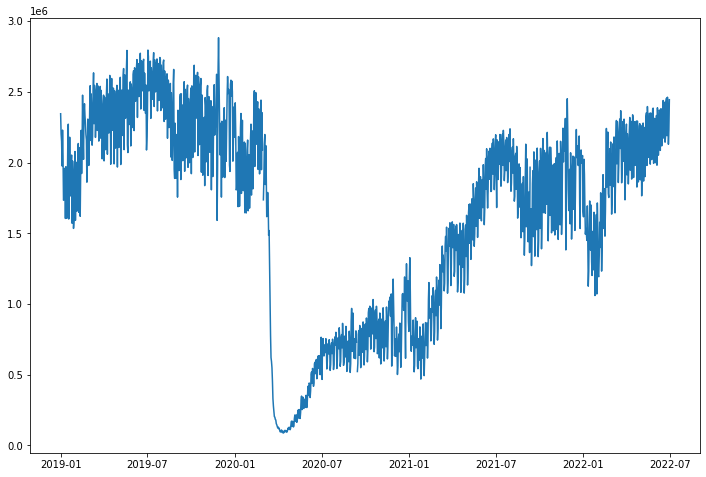

In [126]:
# Daily train travel plots
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(train_travel['ds'], train_travel['travel_train'])
plt.show()


In [127]:
#  Using Facebook Prophet for Store Time Series Forecasting
from prophet import Prophet
from sklearn.metrics import mean_squared_error
# from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [128]:
train_travel.rename(columns={'ds': "ds" , 'travel_train' : "y"}, inplace=True)
tt_model = Prophet(interval_width=0.95,  # 90% C.I. or is it?
                           yearly_seasonality=True, 
                           weekly_seasonality=True, 
                           # changepoint_prior_scale=0.08,
                           # changepoint_range=0.9)
                  )
tt_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
tt_model.add_seasonality(name='yearly', period=365, fourier_order=10, prior_scale=1)
  
#Fit model
tt_model.fit(train_travel)

#Predict the future
tt_future = tt_model.make_future_dataframe(periods=len(test_travel))
tt_pred = tt_model.predict(tt_future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [129]:
pred_test = tt_pred[tt_pred['ds']>=test_travel['ds'][0]]['yhat']

RMSE = mean_squared_error(test_travel['travel_test'], pred_test, squared=False)
print(f"Root Mean Square Error RMSE = {RMSE:.3f}")

Root Mean Square Error RMSE = 259513.520


Prophet Seasonality and Predictions


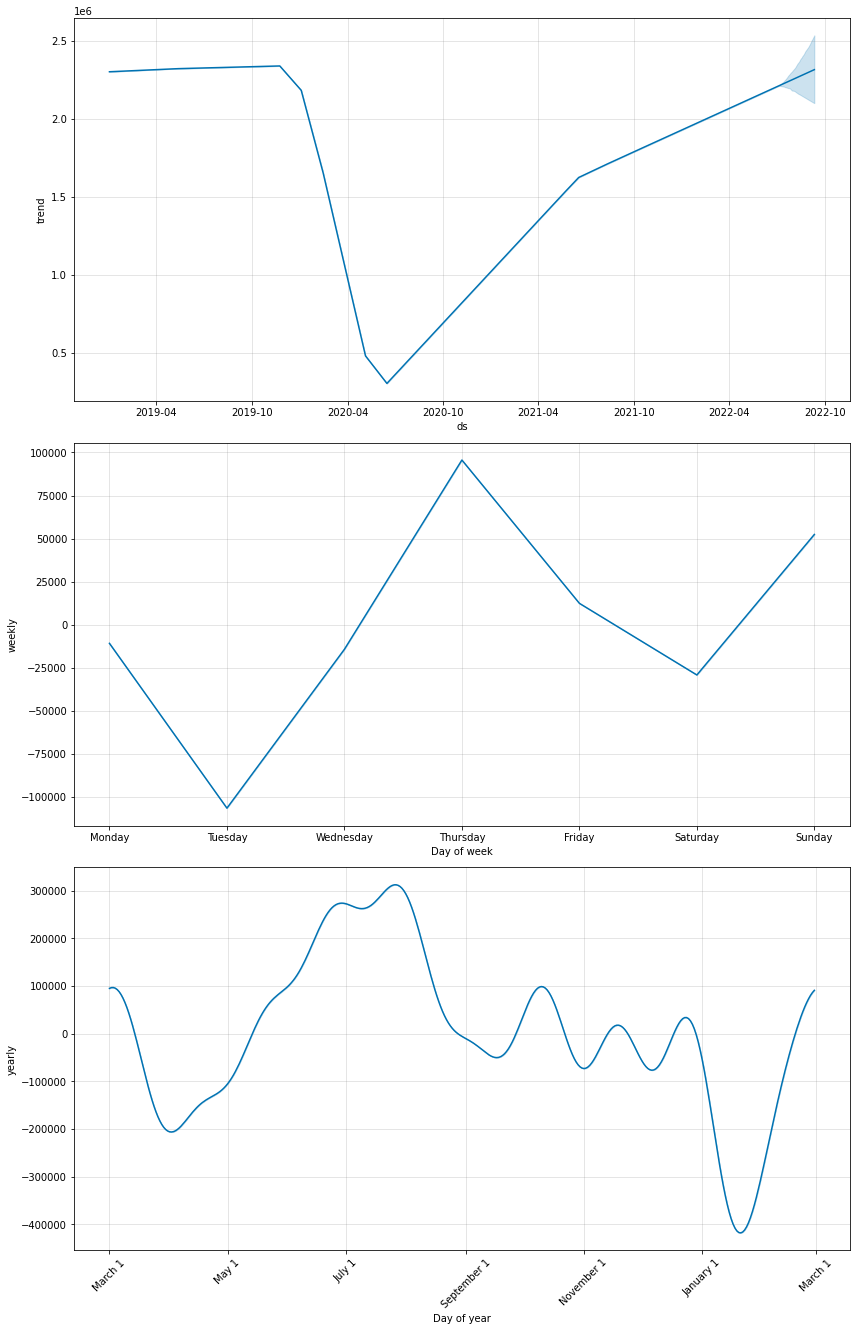

In [130]:
#plt.gca().set(title="Prophet prediction")
print("Prophet Seasonality and Predictions")
tt_model.plot_components(tt_pred, uncertainty=True, weekly_start=1, yearly_start=59, figsize=(12,18))
plt.xticks(rotation=45)
plt.show()

In [131]:
# Add Covid-19 'Holiday' to blunt false linear trend
covid_dates = pd.DataFrame({'ds':pd.date_range(start='3/15/2020', end='3/1/2022')})
covid =pd.DataFrame({'holiday':['Covid-19']})
covid_holiday = covid.join(covid_dates,how='outer').fillna('Covid-19')

tt_model_covid = Prophet(interval_width=0.95,  # 90% C.I. or is it?
                           yearly_seasonality=True, 
                           weekly_seasonality=True, 
                           holidays=covid_holiday
                  )
tt_model_covid.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
tt_model_covid.add_seasonality(name='yearly', period=365, fourier_order=10, prior_scale=1)
  
#Fit model
tt_model_covid.fit(train_travel)

#Predict the future
tt_future_covid = tt_model_covid.make_future_dataframe(periods=len(test_travel)) 
tt_pred_covid = tt_model_covid.predict(tt_future_covid)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [132]:
pred_test_covid = tt_pred_covid[tt_pred_covid['ds']>=test_travel['ds'][0]]['yhat']

RMSE_covid = mean_squared_error(test_travel['travel_test'], pred_test_covid, squared=False)
print(f"Taking into account of Covid-19, treating it as holiday period, RMSE = {RMSE_covid:.3f}")
print(f"By adding special holiday, we reduced RMSE by {(RMSE - RMSE_covid)/RMSE*100:.2f}%")

Taking into account of Covid-19, treating it as holiday period, RMSE = 176226.364
By adding seasonality, we reduced RMSE by 32.09%


Prophet Seasonality and Predictions with Covid-19 Holiday added


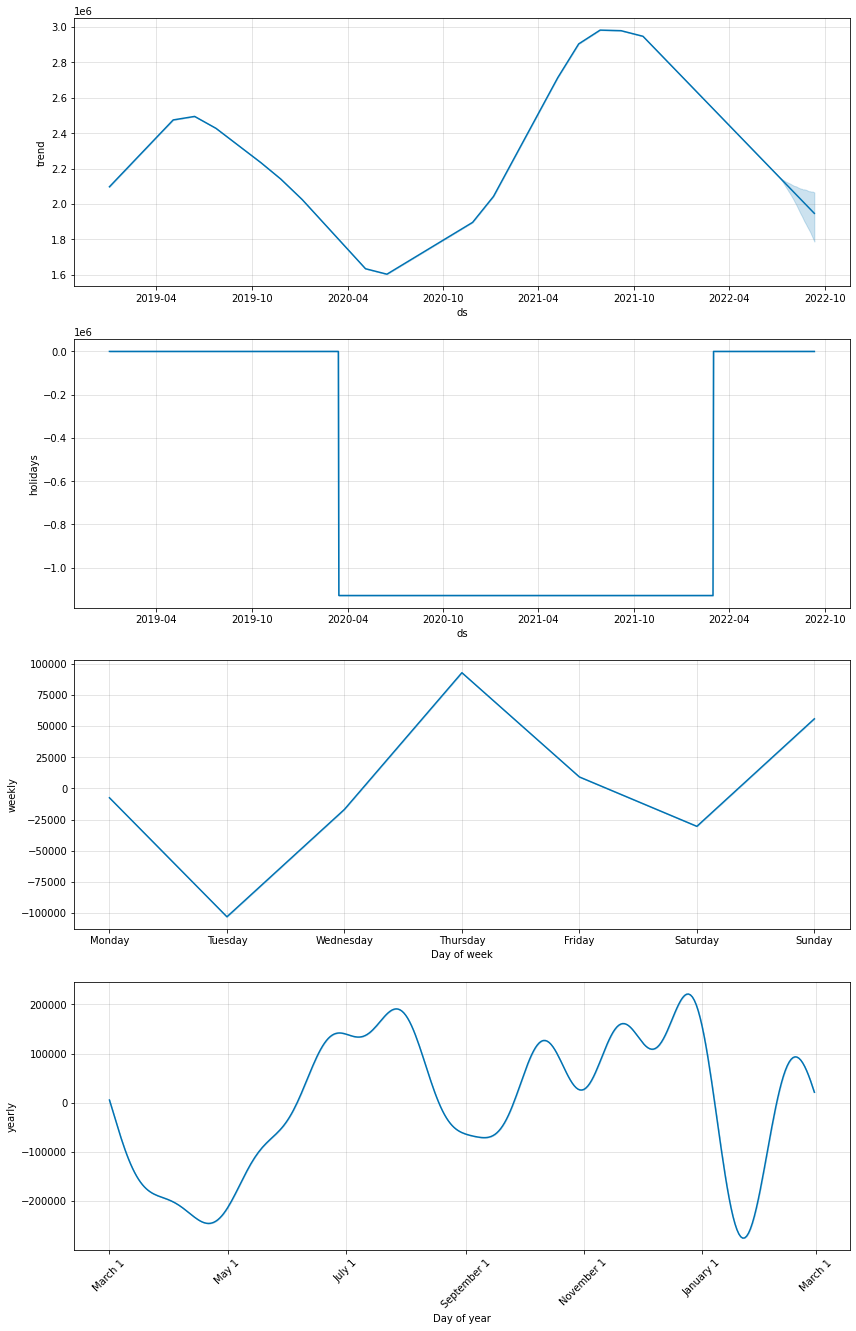

In [133]:
# Prophet plots
print("Prophet Seasonality and Predictions with Covid-19 Holiday added")
tt_model_covid.plot_components(tt_pred_covid, uncertainty=True, weekly_start=1, yearly_start=59, figsize=(12,18))
plt.xticks(rotation=45)
plt.show()